# XGBoost baseline

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
from jupyterthemes import jtplot
import datetime as dt
import seaborn as sns
import json
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

ROOT_DIR = '/home/miguel/github_repos/python-ds'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')

DATA = os.path.join(DATA_INTERIM, 'data.pkl')
PATHS = os.path.join(DATA_PROCESSED, 'paths.pkl')
SIM_DATA = os.path.join(DATA_INTERIM, 'sim_data.pkl')
DISTS_TAS = os.path.join(DATA_INTERIM, 'dists_and_tas.pkl')
TOTAL_DATA = os.path.join(DATA_INTERIM, 'total_data.pkl')

X_TRAIN = os.path.join(DATA_PROCESSED, 'X_train.pkl')
X_VAL = os.path.join(DATA_PROCESSED, 'X_val.pkl')
X_TEST = os.path.join(DATA_PROCESSED, 'X_test.pkl')
Y_TRAIN = os.path.join(DATA_PROCESSED, 'y_train.pkl')
Y_VAL = os.path.join(DATA_PROCESSED, 'y_val.pkl')
Y_TEST = os.path.join(DATA_PROCESSED, 'y_test.pkl')

VAL_SET = os.path.join(DATA_PROCESSED, 'eval_set.pkl')
TEST_SET = os.path.join(DATA_PROCESSED, 'test_set.pkl')

SRC_DIR = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC_DIR)

import data.create_from_sim as cfs
import data.create_from_txt as cft
import data.paths as p
import data.target_creation as tc
import evaluation.eval as ev

import xgboost as xgb

## Test the regressor

In [2]:
X_train = pd.read_pickle(X_TRAIN)
X_val = pd.read_pickle(X_VAL)
y_train = pd.read_pickle(Y_TRAIN)
y_val = pd.read_pickle(Y_VAL)
val_set = pd.read_pickle(VAL_SET)
paths = pd.read_pickle(PATHS)

In [3]:
X_train.head()

bus_stop  codigoBus      distance        lat linea       long  \
1      2960        262  13088.906612 -34.906445  1476 -56.200943   
2      2964        262  13594.140293 -34.906445  1476 -56.200943   
5      2969        262   4117.478660 -34.906445  1476 -56.200943   
6      2970        262   4369.975910 -34.906445  1476 -56.200943   
7      2971        262   5240.147941 -34.906445  1476 -56.200943   

            timestamp       uid            x           y  
1 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
2 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
5 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
6 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943  
7 2018-10-02 17:12:57  1476_262 -1337.282996 -351.931943

In [4]:
y_train.head()

1   2018-10-02 17:59:05.500
2   2018-10-02 17:57:58.000
5   2018-10-02 17:31:42.000
6   2018-10-02 17:33:04.500
7   2018-10-02 17:36:19.500
Name: ta, dtype: datetime64[ns]

In [5]:
model = xgb.XGBRegressor(seed=2018, n_jobs=4)

In [6]:
def preprocess_xgboost(X, y, paths):
    """
    Preprocesses the features / targets for use in XGBoost.
    The targets are differences of time (between the ta and the current timestamp).
    """
    drop_pp = ['codigoBus', 'lat', 'long', 'uid', 'timestamp', 'ta', 'delta',
              'bus_stop', 'codigoParada', 'linea']
    pp_feats = ['distance', 'x', 'y', 'calle', 'esquina', 'ordinal', 'x_s', 'y_s']
    ret_feats = ['timestamp', 'linea', 'bus_stop', 'codigoBus', 'lat', 'long']
    
    if y is not None:
        X_pp = X.join(y)
        X_pp['delta'] = (X_pp['ta'] - X_pp['timestamp']).apply(lambda x: x.seconds)
    else:
        X_pp = X
    
    paths_pp = paths.drop(['lat', 'long'], axis=1).rename(columns={'x': 'x_s',
                                                                        'y': 'y_s'})
    merged = X_pp.merge(paths_pp, left_on=['bus_stop', 'linea'],
                        right_on=['codigoParada', 'linea'])
    
    if y is not None:
        y_pp = merged['delta']
    else:
        y_pp = None
    
    X_pp = merged[pp_feats]
    X_ret = merged[ret_feats]
    
    return X_pp, y_pp, X_ret

In [7]:
from sklearn.preprocessing import LabelEncoder

def get_streets_encoder(paths):
    """ Get a label encoder for all the 'street' features. """
    streets = pd.concat([paths.calle, paths.esquina]).unique()
    encoder = LabelEncoder()
    encoder.fit(streets)
    return encoder

In [8]:
def encode_streets(X, encoder):
    """ Use a label encoder to transform the 'street' features. """
    X[['calle', 'esquina']] = X[['calle', 'esquina']].apply(encoder.transform)
    return X

In [9]:
X_pp, y_pp, X_ret = preprocess_xgboost(X_train, y_train, paths)

In [10]:
X_pp.head()

distance            x           y       calle   esquina  ordinal  \
0  13088.906612 -1337.282996 -351.931943  AV BOLIVIA  FRIBURGO       48   
1  13075.645593 -1322.950854 -358.047664  AV BOLIVIA  FRIBURGO       48   
2  13085.664917 -1331.738445 -366.943258  AV BOLIVIA  FRIBURGO       48   
3  13093.257131 -1331.738445 -416.980975  AV BOLIVIA  FRIBURGO       48   
4  13069.240662 -1311.338681 -391.739727  AV BOLIVIA  FRIBURGO       48   

            x_s          y_s  
0  11606.149234  1594.099504  
1  11606.149234  1594.099504  
2  11606.149234  1594.099504  
3  11606.149234  1594.099504  
4  11606.149234  1594.099504

In [11]:
X_pp.shape

(3398286, 8)

In [12]:
y_pp.shape

(3398286,)

In [13]:
X_pp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3398286 entries, 0 to 3398285
Data columns (total 8 columns):
distance    float64
x           float64
y           float64
calle       object
esquina     object
ordinal     int64
x_s         float64
y_s         float64
dtypes: float64(5), int64(1), object(2)
memory usage: 233.3+ MB


In [14]:
X_ret.head()

timestamp linea  bus_stop  codigoBus        lat       long
0 2018-10-02 17:12:57  1476      2960        262 -34.906445 -56.200943
1 2018-10-02 17:13:12  1476      2960        262 -34.906500 -56.200806
2 2018-10-02 17:13:27  1476      2960        262 -34.906580 -56.200890
3 2018-10-02 17:13:42  1476      2960        262 -34.907030 -56.200890
4 2018-10-02 17:13:57  1476      2960        262 -34.906803 -56.200695

In [15]:
X_ret.shape

(3398286, 6)

In [16]:
encoder = get_streets_encoder(paths)
X_pp = encode_streets(X_pp, encoder)
X_pp.head()

distance            x           y  calle  esquina  ordinal  \
0  13088.906612 -1337.282996 -351.931943     70      363       48   
1  13075.645593 -1322.950854 -358.047664     70      363       48   
2  13085.664917 -1331.738445 -366.943258     70      363       48   
3  13093.257131 -1331.738445 -416.980975     70      363       48   
4  13069.240662 -1311.338681 -391.739727     70      363       48   

            x_s          y_s  
0  11606.149234  1594.099504  
1  11606.149234  1594.099504  
2  11606.149234  1594.099504  
3  11606.149234  1594.099504  
4  11606.149234  1594.099504

In [17]:
%time model.fit(X_pp, y_pp)

CPU times: user 4min 57s, sys: 1.45 s, total: 4min 58s
Wall time: 1min 15s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2018,
       silent=True, subsample=1)

### Internal Validation

In [18]:
X_val_pp, y_val_pp, X_val_ret = preprocess_xgboost(X_val, y_val, paths)
X_val_pp = encode_streets(X_val_pp, encoder)
print(X_val_pp.shape)
print(y_val_pp.shape)
print(X_val_ret.shape)

(54296, 8)
(54296,)
(54296, 6)


In [19]:
X_val_pp.head()

distance            x            y  calle  esquina  ordinal         x_s  \
0  3346.885945  4924.921506  8534.544205      0        0       22  5787.30892   
1    32.491888  5756.185739  5310.002527      0        0       22  5787.30892   
2  3400.636243  4924.921506  8590.141668      0        0       22  5787.30892   
3    32.491888  5756.185739  5310.002527      0        0       22  5787.30892   
4    29.797333  5759.010322  5310.002527      0        0       22  5787.30892   

           y_s  
0  5300.671375  
1  5300.671375  
2  5300.671375  
3  5300.671375  
4  5300.671375

In [20]:
y_val_pp.head()

0    511
1     45
2    496
3     30
4     15
Name: delta, dtype: int64

In [21]:
X_val_ret.head()

timestamp linea  bus_stop  codigoBus        lat       long
0 2018-10-01 19:04:01  7928      6194         41 -34.826527 -56.141083
1 2018-10-01 19:04:01  7928      6194       1101 -34.855526 -56.133137
2 2018-10-01 19:04:16  7928      6194         41 -34.826027 -56.141083
3 2018-10-01 19:04:16  7928      6194       1101 -34.855526 -56.133137
4 2018-10-01 19:04:31  7928      6194       1101 -34.855526 -56.133110

In [22]:
y_val_pred = model.predict(X_val_pp)

In [23]:
y_val_pred[:10]

array([  3077.86962891,  32371.79882812,   3077.86962891,  32371.79882812,
        32194.73242188,   3003.38793945,  32194.73242188,   3003.38793945,
         3129.9440918 ,  32371.79882812], dtype=float32)

In [24]:
from sklearn.metrics import mean_squared_error as mse

In [25]:
mse(y_val_pp.values, y_val_pred)

581184304.77370536

In [95]:
y_pp.describe()

count    3.398286e+06
mean     3.353776e+03
std      6.085560e+03
min      0.000000e+00
25%      7.420000e+02
50%      1.807000e+03
75%      5.102000e+03
max      8.639900e+04
Name: delta, dtype: float64

In [97]:
y_pp.max()/3600.0

23.999722222222221

In [107]:
y_pp.hist(bins=150)
plt.vlines(3*3600, 0, 700000, colors='r')

In [335]:
y_pp.hist(bins=150)
plt.vlines(3*3600, 0, 700000, colors='r')

## Create a predictor

In [337]:
XGB_BASELINE_PATH = os.path.join(ROOT_DIR, 'models', 'xgb_baseline.pkl')
ID_LINEA = 'id_linea'
ID_PARADA = 'id_parada'
ID_BUS = 'id_bus'
LOCATION = 'location'
TEA = 'tea'


class XGBBaselinePredictor(object):
    """
    Baseline XGBoost predictor

    Args:
        filepath (str): The filepath to save this predictor.

    Attributes:
        dummy_delta (float): The constant value to predict for all samples.
            This is a value in seconds that is added to the current timestamp.
    """

    def __init__(self, paths, filepath=XGB_BASELINE_PATH):
        self.filepath = filepath
        self.model = xgb.XGBRegressor(seed=2018, n_jobs=4)
        self.encoder = None
        self.paths = paths
        self.incoming_buses = None
        self.delta_max = 3600.0 * 3.0

    def fit(self, X, y):
        """
        Fit the training data. Only to be run offline.

        Args:
            X (pandas.DataFrame): Contains the training features. The columns are,
                in principle:
                [bus_stop, codigoBus, distance, lat, linea, long, timestamp, uid, x, y]
            y (pandas.Series): Contains the times of arrival ('ta'). It's type is pd.Timestamp.
        """
        self.dummy_delta = None

        X_pp, y_pp, _ = preprocess_xgboost(X, y, self.paths)
        self.encoder = get_streets_encoder(self.paths)
        X_pp = encode_streets(X_pp, self.encoder)
        self.model.fit(X_pp, y_pp)

        self.save_predictor()

    def update(self, X):
        """
        Update the training. This function is called each time there is a new datum
        available from the simulator.

        Args:
            X (pandas.DataFrame): Contains the training features in the columns.
                Each row is a sample. The columns are, in principle:
                [bus_stop, codigoBus, distance, lat, linea, long, timestamp, uid, x, y]
        """
        # TODO: Incremental learning with the xgb_model param.
        # Learn to save and load it, maybe.

        # Predict
        X_val_pp, y_val_pp, X_val_ret = preprocess_xgboost(X, None, self.paths)
        X_val_pp = encode_streets(X_val_pp, self.encoder)
        y_val_pred = self.model.predict(X_val_pp)
        X_val_ret['delta'] = y_val_pred
        X_val_ret['tea'] = X_val_ret['timestamp'] + X_val_ret.delta.apply(
            lambda x: dt.timedelta(seconds=x))

        # Filter outliers
        X_val_ret = X_val_ret[X_val_ret.delta < self.delta_max]

        if self.incoming_buses is None:
            self.incoming_buses = X_val_ret
        else:
            self.incoming_buses = pd.concat([self.incoming_buses, X_val_ret])

        # Smooth the paths in time
        self.smooth_preds()
        # Remove duplicates (possible bug fix)
        self.incoming_buses = self.incoming_buses.drop_duplicates(
            subset=['bus_stop', 'linea', 'codigoBus'], keep='last')
        self.incoming_buses.to_sql()

    def query(self, stop, line, current_time):
        """
        Predict the time of arrival to the bus stop 'stop' for the next bus of
        the line 'line'.

        Args:
            stop (int): The bus stop integer code.
            line (str): The line string code.
            current_time (pandas.Timestamp): The current time.

        Returns:
            dict: A dictionary with:
            ['id_linea': int, 'id_parada': int, 'id_bus': string,
            'location': GeoJSON, 'tea': float (seconds until arrival)]
        """
        default_ret = {}
        valid_buses = self.incoming_buses[(self.incoming_buses.linea == line)
                                          & (self.incoming_buses.bus_stop == stop)
                                          & (self.incoming_buses.tea > current_time)]
        if valid_buses.empty:
            return default_ret

        next_bus = valid_buses[valid_buses.tea == valid_buses.tea.min()].iloc[0]
        return self.format_output(next_bus, current_time)

    def save_predictor(self):
        """ Save this object in pickle format. """
        with open(self.filepath, 'wb') as file:
            pickle.dump(self, file)

    @classmethod
    def load_predictor(filepath=XGB_BASELINE_PATH):
        """ Save a predictor from pickle format. """
        with open(filepath, 'r') as file:
            predictor = pickle.load(file)
        return predictor

    @staticmethod
    def create_geojson(x, y):
        """ Create a GeoJSON from coordinates. """
        return {'type': 'geo:json',
                'value': {'type': 'Point',
                          'coordinates': [x, y]},
                'metadata': {}}

    def format_output(self, raw_output, current_time):
        """
        Formats the output of the query function, to fit the requested format.

        Args:
            raw_output (pd.Series): A row of self.data that was selected as
                the best answer.
        Returns:
            dict: A dictionary that contains all the requested data for a query.
        """
        return {ID_LINEA: raw_output.linea,
                ID_PARADA: raw_output.bus_stop,
                ID_BUS: raw_output.codigoBus,
                LOCATION: self.create_geojson(
                    raw_output.long, raw_output.lat),
                TEA: (raw_output.tea - current_time).seconds}

    @staticmethod
    def smooth_update(old_record, new_record, learning_rate=0.1):
        coherence_period = 70
        if old_record is None:
            return new_record
        if new_record is None:
            return old_record
        delta_t = (new_record.timestamp - old_record.timestamp).seconds
        if delta_t < 0:  # The order is not OK
            return old_record  # In fact, it is the newest
        if delta_t > coherence_period:
            return new_record
        else:
            ret_record = new_record.copy()
            ret_record['tea'] = pd.Timestamp.fromtimestamp(
                old_record.tea.timestamp() * (1 - learning_rate)
                + new_record.tea.timestamp() * learning_rate)
            return ret_record

    @staticmethod
    def smooth_path(path_df, **kwargs):
        sm_list = []
        prev_row = None
        for index, row in path_df.iterrows():
            sm_record = XGBBaselinePredictor.smooth_update(prev_row, row, **kwargs)
            sm_list.append(sm_record)
            prev_row = sm_record
        return pd.DataFrame(sm_list)

    @staticmethod
    def smooth_path_value(path_df, **kwargs):
        prev_row = None
        for index, row in path_df.iterrows():
            sm_record = XGBBaselinePredictor.smooth_update(prev_row, row, **kwargs)
            prev_row = sm_record
        return sm_record

    def smooth_preds(self):
        self.incoming_buses = self.incoming_buses.groupby(
            ['linea', 'bus_stop', 'codigoBus']).apply(
            XGBBaselinePredictor.smooth_path_value).reset_index(drop=True)

In [338]:
predictor = XGBBaselinePredictor(paths)

In [339]:
%time predictor.fit(X_train, y_train)

CPU times: user 6min, sys: 3.23 s, total: 6min 3s
Wall time: 2min 16s


In [340]:
predictor.incoming_buses

In [341]:
%time predictor.update(X_val)

CPU times: user 16.3 s, sys: 48.1 ms, total: 16.3 s
Wall time: 15.3 s


In [342]:
incoming_buses = predictor.incoming_buses
print(incoming_buses.shape)
incoming_buses.head()

(2218, 8)


timestamp  linea  bus_stop  codigoBus        lat       long  \
0 2018-10-01 19:12:17   1476      2960        286 -34.896305 -56.122917   
1 2018-10-01 19:12:17   1476      2964        286 -34.896305 -56.122917   
2 2018-10-01 19:12:17   1476      2967        286 -34.896305 -56.122917   
3 2018-10-01 19:12:17   1476      2968        286 -34.896305 -56.122917   
4 2018-10-01 19:12:17   1476      2969        574 -34.905640 -56.186974   

         delta                        tea  
0  1911.411133 2018-10-01 19:44:11.111111  
1  1468.147217 2018-10-01 19:38:15.198448  
2  2171.906250 2018-10-01 19:47:55.192925  
3  2199.903564 2018-10-01 19:48:23.190239  
4  1932.329102 2018-10-01 19:46:15.048439

In [343]:
last_timestamp = X_val[X_val.timestamp == X_val.timestamp.unique()[-2]]
last_timestamp.shape

(1506, 10)

In [344]:
%time predictor.update(last_timestamp)

CPU times: user 2.09 s, sys: 15.9 ms, total: 2.11 s
Wall time: 1.55 s


In [345]:
incoming_buses = predictor.incoming_buses
print(incoming_buses.shape)
incoming_buses.head()

(2218, 8)


timestamp  linea  bus_stop  codigoBus        lat       long  \
0 2018-10-01 19:10:01    217      1145         41 -34.855717 -56.223316   
1 2018-10-01 19:06:01    217      1145         83 -34.854650 -56.221767   
3 2018-10-01 19:10:46    217      1211         41 -34.855200 -56.222683   
4 2018-10-01 19:07:16    217      1211         83 -34.854633 -56.221783   
6 2018-10-01 19:06:31    217      1565         41 -34.864250 -56.210020   

         delta                        tea  
0  4221.536621 2018-10-01 20:12:39.936874  
1  3940.963135 2018-10-01 20:08:22.732835  
3  4221.536621 2018-10-01 20:14:06.717972  
4  3940.963135 2018-10-01 20:09:50.868588  
6  3779.282227 2018-10-01 20:08:00.672028

In [346]:
s = predictor.incoming_buses[predictor.incoming_buses.codigoBus == 41]
s[s.linea == 217]

timestamp  linea  bus_stop  codigoBus        lat       long  \
0   2018-10-01 19:10:01    217      1145         41 -34.855717 -56.223316   
3   2018-10-01 19:10:46    217      1211         41 -34.855200 -56.222683   
6   2018-10-01 19:06:31    217      1565         41 -34.864250 -56.210020   
8   2018-10-01 19:08:01    217      1567         41 -34.858383 -56.217533   
151 2018-10-01 19:06:01    217      4255         41 -34.858818 -56.216950   
156 2018-10-01 19:11:47    217      4586         41 -34.856083 -56.223750   

           delta                        tea  
0    4221.536621 2018-10-01 20:12:39.936874  
3    4221.536621 2018-10-01 20:14:06.717972  
6    3779.282227 2018-10-01 20:08:00.672028  
8    3779.282227 2018-10-01 20:10:00.473942  
151  3807.453613 2018-10-01 20:08:11.566687  
156  4156.947754 2018-10-01 20:16:30.439503

In [347]:
predictor.incoming_buses.tea.hist(bins=50)

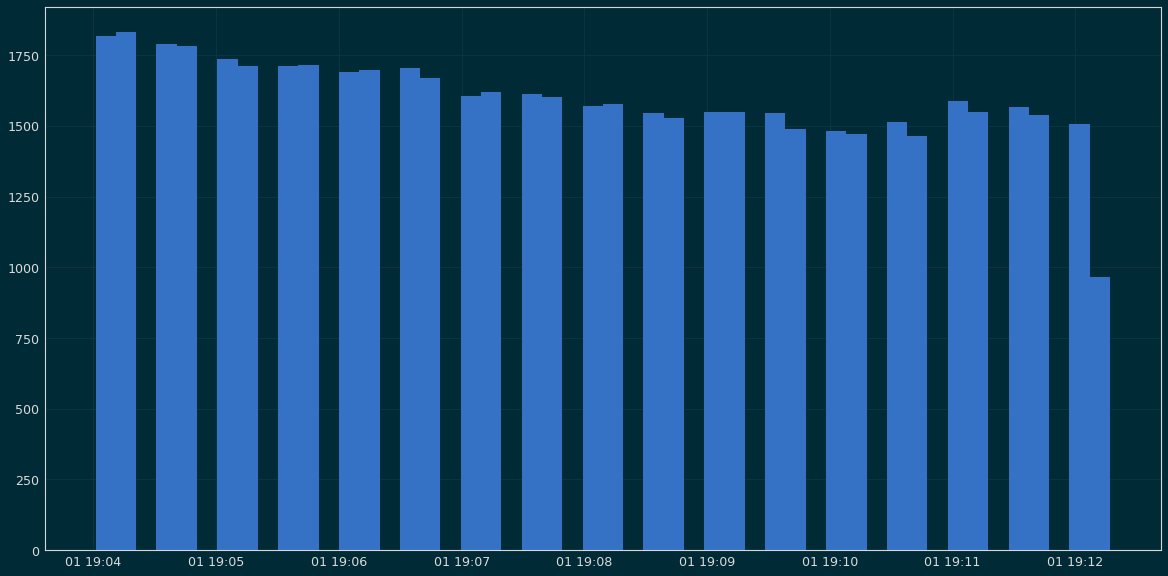

In [325]:
X_val.timestamp.hist(bins=50)

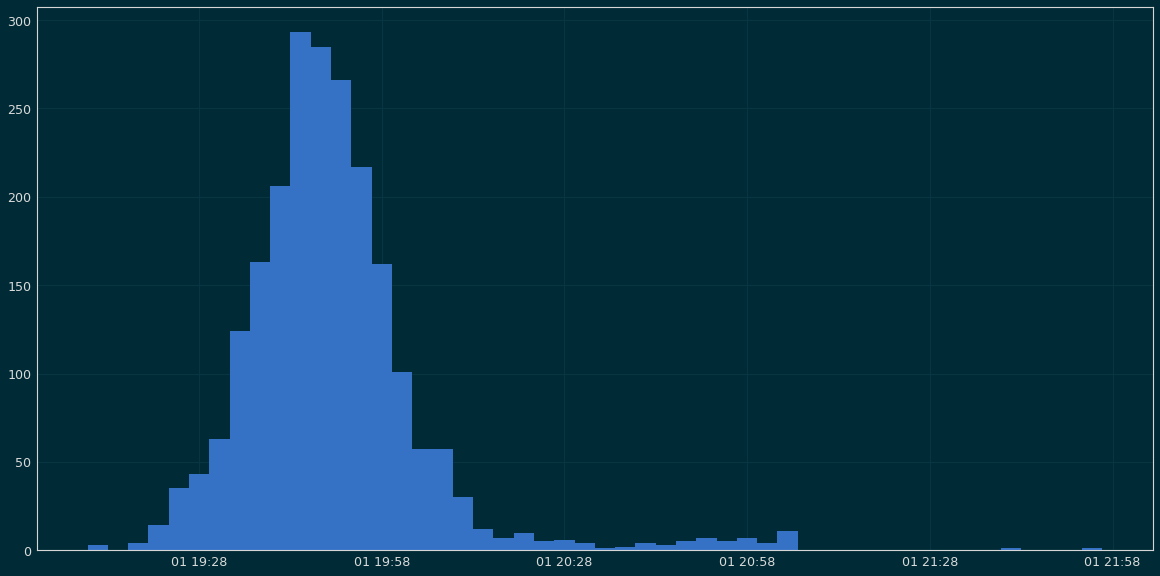

In [326]:
incoming_buses.tea.hist(bins=50)

In [327]:
current_time = X_val_ret.timestamp.iloc[0]
current_time

Timestamp('2018-10-01 19:04:01')

In [328]:
# current_time = pd.Timestamp('2018-10-05')
# current_time

In [329]:
line, stop = ('7928', 6194)

In [330]:
valid_buses = incoming_buses[(incoming_buses.linea==line) 
                             & (incoming_buses.bus_stop==stop)
                             & (incoming_buses.tea > current_time)]
print(valid_buses.shape)
valid_buses.head()

/home/miguel/anaconda3/envs/desafiotea/lib/python3.6/site-packages/pandas/core/ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [ ]:
valid_buses.empty

In [ ]:
# IF valid_buses is empty, return null json
next_bus = valid_buses[valid_buses.tea == valid_buses.tea.min()].iloc[0]
next_bus

In [ ]:
(next_bus.tea - current_time).seconds

In [ ]:
predictor.query(stop, line, current_time)

In [149]:
predictor.update(X_val)

In [150]:
predictor.incoming_buses.head()

timestamp linea  bus_stop  codigoBus        lat       long  \
0 2018-10-01 19:04:01  7928      6194         41 -34.826527 -56.141083   
2 2018-10-01 19:04:16  7928      6194         41 -34.826027 -56.141083   
5 2018-10-01 19:04:31  7928      6194         41 -34.828415 -56.141110   
7 2018-10-01 19:04:46  7928      6194         41 -34.828415 -56.141110   
8 2018-10-01 19:05:01  7928      6194         41 -34.828750 -56.141083   

         delta                        tea  
0  3077.869629 2018-10-01 19:55:18.869629  
2  3077.869629 2018-10-01 19:55:33.869629  
5  3003.387939 2018-10-01 19:54:34.387939  
7  3003.387939 2018-10-01 19:54:49.387939  
8  3129.944092 2018-10-01 19:57:10.944092

In [151]:
incoming_buses.shape

(52359, 8)

In [162]:
print(valid_buses.shape)
valid_buses.head()

(35, 8)


timestamp linea  bus_stop  codigoBus        lat       long  \
0 2018-10-01 19:04:01  7928      6194         41 -34.826527 -56.141083   
2 2018-10-01 19:04:16  7928      6194         41 -34.826027 -56.141083   
5 2018-10-01 19:04:31  7928      6194         41 -34.828415 -56.141110   
7 2018-10-01 19:04:46  7928      6194         41 -34.828415 -56.141110   
8 2018-10-01 19:05:01  7928      6194         41 -34.828750 -56.141083   

         delta                        tea  
0  3077.869629 2018-10-01 19:55:18.869629  
2  3077.869629 2018-10-01 19:55:33.869629  
5  3003.387939 2018-10-01 19:54:34.387939  
7  3003.387939 2018-10-01 19:54:49.387939  
8  3129.944092 2018-10-01 19:57:10.944092

In [224]:
def smooth_update(old_record, new_record, learning_rate=0.1):
    coherence_period = 70
    if old_record is None:
        return new_record
    if new_record is None:
        return old_record
    delta_t = (new_record.timestamp - old_record.timestamp).seconds
    if delta_t < 0:  # The order is not OK
        return old_record  # In fact, it is the newest
    if delta_t > coherence_period:
        return new_record
    else:
        ret_record = new_record.copy()
        ret_record['tea'] = pd.Timestamp.fromtimestamp(
            old_record.tea.timestamp() * (1 - learning_rate) 
            + new_record.tea.timestamp() * learning_rate)
        return ret_record

In [194]:
pd.Timestamp.fromtimestamp(valid_buses.iloc[0].tea.timestamp())

Timestamp('2018-10-01 19:55:18.869629')

In [266]:
smooth_update(valid_buses.iloc[0], valid_buses.iloc[1])

timestamp           2018-10-01 19:04:16
linea                              7928
bus_stop                           6194
codigoBus                            41
lat                             -34.826
long                           -56.1411
delta                           3077.87
tea          2018-10-01 19:55:20.369629
Name: 2, dtype: object

In [267]:
def smooth_path_value(path_df, **kwargs):
    prev_row = None
    for index, row in path_df.iterrows():
        sm_record = smooth_update(prev_row, row, **kwargs)
        prev_row = sm_record
    return sm_record

In [225]:
def smooth_path(path_df, **kwargs):
    sm_list = []
    prev_row = None
    for index, row in path_df.iterrows():
        sm_record = smooth_update(prev_row, row, **kwargs)
        sm_list.append(sm_record)
        prev_row = sm_record
    
    return pd.DataFrame(sm_list)

In [230]:
sm_df = smooth_path(valid_buses, learning_rate=0.1)
print(sm_df.shape)
sm_df.head()

(35, 8)


timestamp linea  bus_stop  codigoBus        lat       long  \
0 2018-10-01 19:04:01  7928      6194         41 -34.826527 -56.141083   
2 2018-10-01 19:04:16  7928      6194         41 -34.826027 -56.141083   
5 2018-10-01 19:04:31  7928      6194         41 -34.828415 -56.141110   
7 2018-10-01 19:04:46  7928      6194         41 -34.828415 -56.141110   
8 2018-10-01 19:05:01  7928      6194         41 -34.828750 -56.141083   

         delta                        tea  
0  3077.869629 2018-10-01 19:55:18.869629  
2  3077.869629 2018-10-01 19:55:20.369629  
5  3003.387939 2018-10-01 19:55:15.771460  
7  3003.387939 2018-10-01 19:55:13.133108  
8  3129.944092 2018-10-01 19:55:24.914206

In [231]:
teas = valid_buses.tea.apply(lambda x: x.timestamp())
((teas - teas.iloc[0])).plot()

teas = sm_df.tea.apply(lambda x: x.timestamp())
((teas - teas.iloc[0])).plot(style='r')

In [158]:
incoming = predictor.incoming_buses

In [233]:
incoming.head()

timestamp linea  bus_stop  codigoBus        lat       long  \
0 2018-10-01 19:04:01  7928      6194         41 -34.826527 -56.141083   
2 2018-10-01 19:04:16  7928      6194         41 -34.826027 -56.141083   
5 2018-10-01 19:04:31  7928      6194         41 -34.828415 -56.141110   
7 2018-10-01 19:04:46  7928      6194         41 -34.828415 -56.141110   
8 2018-10-01 19:05:01  7928      6194         41 -34.828750 -56.141083   

         delta                        tea  
0  3077.869629 2018-10-01 19:55:18.869629  
2  3077.869629 2018-10-01 19:55:33.869629  
5  3003.387939 2018-10-01 19:54:34.387939  
7  3003.387939 2018-10-01 19:54:49.387939  
8  3129.944092 2018-10-01 19:57:10.944092

In [237]:
%time sm_incoming = incoming.groupby(['linea', 'bus_stop', 'codigoBus']).apply(smooth_path)

CPU times: user 41.7 s, sys: 9.89 ms, total: 41.7 s
Wall time: 41.7 s


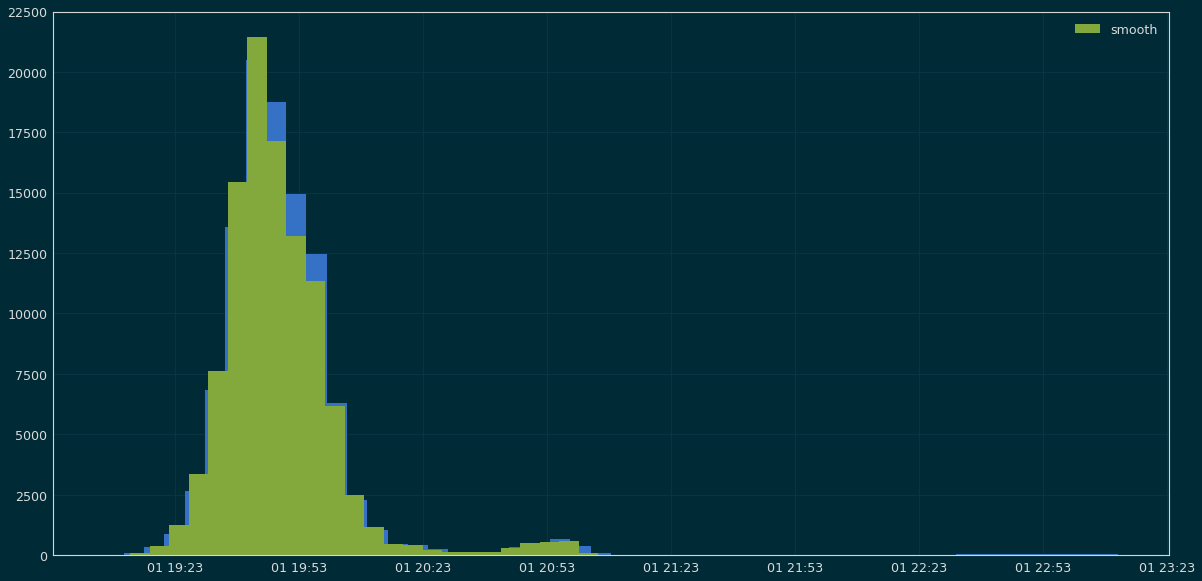

In [246]:
incoming.tea.hist(bins=50)
sm_incoming.tea.hist(bins=50, label='smooth')
plt.legend()

In [269]:
%time sm_incoming = incoming.groupby(['linea', 'bus_stop', 'codigoBus']).apply(smooth_path_value)

CPU times: user 28.7 s, sys: 40.8 ms, total: 28.8 s
Wall time: 28.8 s


In [273]:
print(sm_incoming.shape)
sm_incoming.reset_index(drop=True).head()

(2223, 8)


timestamp  linea  bus_stop  codigoBus        lat       long  \
0 2018-10-01 19:12:17   1476      2960        286 -34.896305 -56.122917   
1 2018-10-01 19:12:17   1476      2964        286 -34.896305 -56.122917   
2 2018-10-01 19:12:17   1476      2967        286 -34.896305 -56.122917   
3 2018-10-01 19:12:17   1476      2968        286 -34.896305 -56.122917   
4 2018-10-01 19:12:17   1476      2969        574 -34.905640 -56.186974   

         delta                        tea  
0  1911.411133 2018-10-01 19:44:11.111111  
1  1468.147217 2018-10-01 19:38:15.198448  
2  2171.906250 2018-10-01 19:47:55.192925  
3  2199.903564 2018-10-01 19:48:23.190239  
4  1932.329102 2018-10-01 19:46:15.048439

In [91]:
inc = predictor.incoming_buses.drop_duplicates(
    subset=['bus_stop', 'linea', 'codigoBus'], keep='last')
print(inc.shape)
inc.head()

(2281, 7)


timestamp linea  bus_stop  codigoBus        lat       long  \
23  2018-10-01 19:06:46  7928      6194       1101 -34.855500 -56.133167   
45  2018-10-01 19:12:17  7928      6194         41 -34.855360 -56.133110   
59  2018-10-01 19:07:16  7902      2907       1076 -34.881668 -56.115276   
78  2018-10-01 19:08:31  7902      2908       1076 -34.881306 -56.117750   
124 2018-10-01 19:12:02  7902      3216       1076 -34.870167 -56.130000   

                           tea  
23  2018-10-02 04:06:17.798828  
45  2018-10-02 04:11:48.798828  
59  2018-10-01 23:52:45.619141  
78  2018-10-01 23:43:50.896484  
124 2018-10-01 19:50:59.202637

## Evaluate

def parallel_query(samples):
            return ev.query_samples_pred(samples, predictor, 'tea')
    
%time error, results = ev.evaluate_predictor(predictor, parallel_query_fun=parallel_query)